`im2col` とその逆変換 `col2im` の実装。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def im2col(images, filter_height, filter_width, out_height, out_width, stride, padding):
    """im2col 実装

    Args:
        images (np.Array): バッチ-チャンネル-画像の縦軸-画像の横軸 の4次元テンソル
        filter_height (integer): フィルタの高さ
        filter_width (integer): フィルタの幅
        out_height (integer): 出力見込みの画像高さ
        out_width (integer): 出力見込みの画像幅
        stride (integer): フィルタを適用するピクセル幅
        padding (integer): 画像の周囲に埋め込む 0 パディング幅
    """
    batch_size, channels, img_hight, img_width = images.shape
    img_padding = np.pad(images, [(0,0), (0,0), (padding, padding), (padding, padding)], "constant")
    cols = np.zeros((batch_size, channels, filter_height, filter_width, out_height, out_width))
    for h in range(filter_height):
        h_lim = h + stride*out_height
        for w in range(filter_width):
            w_lim = w + stride*out_width
            cols[:, :, h, w, :, :] = img_padding[:, :, h:h_lim:stride, w:w_lim:stride]
    cols = cols.transpose(1, 2, 3, 0, 4, 5).reshape(channels*filter_height*filter_width, batch_size*out_height*out_width)
    return cols

def col2im(cols, img_shape, filter_height, filter_width, out_height, out_width, stride, padding):
    """col2im, im2col の逆実装

    Args:
        cols (np.Array): im2col されたデータ
        img_shape (Array): バッチサイズ,チャンネル数,画像高さ,画像幅の配列
        filter_height (integer): フィルタの高さ
        filter_width (integer): フィルタの幅
        out_height (integer): 出力予定の画像高さ
        out_width (integer): 出力予定の画像幅
        stride (integer): フィルタ適用幅
        padding (integer): 画像周囲に埋め込まれる 0 パディング幅
    """
    batch_size, channels, img_hight, img_width = img_shape
    cols = cols.reshape(channels, filter_height, filter_width, batch_size, out_height, out_width, ).transpose(3, 0, 1, 2, 4, 5)
    images = np.zeros((batch_size, channels, img_hight+2*padding+stride-1, img_width+2*padding+stride-1))
    for h in range(filter_height):
        h_lim = h + stride*out_height
        for w in range(filter_width):
            w_lim = w + stride*out_width
            images[:, :, h:h_lim:stride, w:w_lim:stride] += cols[:, :, h, w, :, :]
    return images[:, :, padding:img_hight+padding, padding:img_width+padding]


インターフェースだけ定義

In [2]:
class ILayer:
    def forward(self, x):
        pass
    def backward(self, grad_y):
        pass
    def update(self):
        pass

各層を実装してく。  
畳み込み層

In [3]:
eta = 0.01  # 学習係数


class ConvLayer:
    
    # n_bt:バッチサイズ, x_ch:入力チャンネル数, x_h:入力画像高さ, x_w:入力画像幅
    # n_flt:フィルタ数, flt_h:フィルタ高さ, flt_w:フィルタ幅
    # stride:ストライド幅, pad:パディング幅
    # y_ch:出力チャンネル数, y_h:出力高さ, y_w:出力幅
    
    def __init__(self, x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad):

        # パラメータをまとめる
        self.params = (x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad)
        
        # フィルタとバイアスの初期値
        self.w = wb_width * np.random.randn(n_flt, x_ch, flt_h, flt_w)
        self.b = wb_width * np.random.randn(1, n_flt)
        
        # 出力画像のサイズ
        self.y_ch = n_flt  # 出力チャンネル数
        self.y_h = (x_h - flt_h + 2*pad) // stride + 1  # 出力高さ
        self.y_w = (x_w - flt_w + 2*pad) // stride + 1  # 出力幅
 
        # AdaGrad用
        self.h_w = np.zeros((n_flt, x_ch, flt_h, flt_w)) + 1e-8
        self.h_b = np.zeros((1, n_flt)) + 1e-8
        
    def forward(self, x):
        n_bt = x.shape[0] 
        x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # 入力画像とフィルタを行列に変換
        self.cols = im2col(x, flt_h, flt_w, y_h, y_w, stride, pad)
        self.w_col = self.w.reshape(n_flt, x_ch*flt_h*flt_w)
        
        # 出力の計算: 行列積、バイアスの加算、活性化関数
        u = np.dot(self.w_col, self.cols).T + self.b
        self.u = u.reshape(n_bt, y_h, y_w, y_ch).transpose(0, 3, 1, 2)
        self.y = np.where(self.u <= 0, 0, self.u)
    
    def backward(self, grad_y):
        n_bt = grad_y.shape[0]
        x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # delta
        delta = grad_y * np.where(self.u <= 0, 0, 1)
        delta = delta.transpose(0,2,3,1).reshape(n_bt*y_h*y_w, y_ch)
        
        # フィルタとバイアスの勾配
        grad_w = np.dot(self.cols, delta)
        self.grad_w = grad_w.T.reshape(n_flt, x_ch, flt_h, flt_w)
        self.grad_b = np.sum(delta, axis=0)
        
        # 入力の勾配
        grad_cols = np.dot(delta, self.w_col)
        x_shape = (n_bt, x_ch, x_h, x_w)
        self.grad_x = col2im(grad_cols.T, x_shape, flt_h, flt_w, y_h, y_w, stride, pad)
        
    def update(self):
        self.h_w += self.grad_w * self.grad_w
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        
        self.h_b += self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b

Pooling層

In [4]:
class PoolingLayer(ILayer):
    
    # batch_size:バッチサイズ, x_ch:入力チャンネル数, x_h:入力画像高さ, x_w:入力画像幅
    # pool:プーリング領域のサイズ, pad:パディング幅
    # y_ch:出力チャンネル数, y_h:出力高さ, y_w:出力幅
    def __init__(self, x_ch, x_h, x_w, pool, pad):
        
        # パラメータをまとめる
        self.params = (x_ch, x_h, x_w, pool, pad)
        
        # 出力画像のサイズ
        self.y_ch = x_ch  # 出力チャンネル数
        self.y_h = x_h//pool if x_h%pool==0 else x_h//pool+1  # 出力高さ
        self.y_w = x_w//pool if x_w%pool==0 else x_w//pool+1  # 出力幅
        
    def forward(self, x):
        n_bt = x.shape[0] 
        x_ch, x_h, x_w, pool, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # 入力画像を行列に変換
        cols = im2col(x, pool, pool, y_h, y_w, pool, pad)
        cols = cols.T.reshape(n_bt*y_h*y_w*x_ch, pool*pool)
        
        # 出力の計算: Maxプーリング
        y = np.max(cols, axis=1)
        self.y = y.reshape(n_bt, y_h, y_w, x_ch).transpose(0, 3, 1, 2)
        
        # 最大値のインデックスを保存
        self.max_index = np.argmax(cols, axis=1)
    
    def backward(self, grad_y):
        n_bt = grad_y.shape[0] 
        x_ch, x_h, x_w, pool, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # 出力の勾配の軸を入れ替え
        grad_y = grad_y.transpose(0, 2, 3, 1)
        
        # 行列を作成し、各列の最大値であった要素にのみ出力の勾配を入れる
        grad_cols = np.zeros((pool*pool, grad_y.size))
        grad_cols[self.max_index.reshape(-1), np.arange(grad_y.size)] = grad_y.reshape(-1) 
        grad_cols = grad_cols.reshape(pool, pool, n_bt, y_h, y_w, y_ch)
        grad_cols = grad_cols.transpose(5,0,1,2,3,4) 
        grad_cols = grad_cols.reshape( y_ch*pool*pool, n_bt*y_h*y_w)

        # 入力の勾配
        x_shape = (n_bt, x_ch, x_h, x_w)
        self.grad_x = col2im(grad_cols, x_shape, pool, pool, y_h, y_w, pool, pad)

いつも通りの実装

In [5]:
wb_width = 0.1  # 重みとバイアスの広がり方

class Neuron(ILayer):
    def __init__(self, n_upper, n, activation_function, differential_function):
        self.w = wb_width * np.random.randn(n_upper, n) # ランダムなのが確立勾配法
        self.b = wb_width * np.random.randn(n)
        self.grad_w = np.zeros((n_upper, n))
        self.grad_b = np.zeros((n))
        self.activation_function = activation_function
        self.differential_function = differential_function

    def update(self):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b
    
    def forward(self, x):
        self.x = x
        u = x.dot(self.w) + self.b
        self.y = self.activation_function(u)
        return self.y

    def backward(self, t):
        delta = self.differential_function(self.y, t)
        self.grad_w = self.x.T.dot(delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = delta.dot(self.w.T)
        return self.grad_x


class AdaNeuron(Neuron):
    def __init__(self, n_upper, n, activation_function, differential_function):
        super().__init__(n_upper, n, activation_function, differential_function)
        self.h_w = np.zeros((n_upper, n)) + 1e-8
        self.h_b = np.zeros((n)) + 1e-8

    def update(self):
        # ここだけ更新
        self.h_w += (self.grad_w * self.grad_w)
        self.h_b += (self.grad_b * self.grad_b)
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b


class Output(AdaNeuron):
    pass


class Middle(AdaNeuron):
    def backward(self, grad_y):
        delta = self.differential_function(grad_y, self.y)
        self.grad_w = self.x.T.dot(delta)
        self.grad_b = delta.sum(axis = 0)
        self.grad_x = delta.dot(self.w.T)
        return self.grad_x


class Dropout:
    def __init__(self, dropout_rate):
        self.dropout_rate = dropout_rate
    
    def forward(self, x, is_train):
        if is_train:
            rand = np.random.rand(*x.shape)
            self.dropout = np.where(rand > self.dropout_rate, 1, 0)
            self.y = x * self.dropout
        else:
            self.y = (1 - self.dropout_rate) * x
        return self.y
    
    def backward(self, grad_y):
        self.grad_x = grad_y * self.dropout
        return self.grad_x


追加関数類

In [6]:

def relu_func(x):
    return np.where(x <= 0, 0, x)

def relu_func_dash(y, t):
    return y * np.where(t <= 0, 0, 1)

def soft_max(u):
    return np.exp(u) / np.sum(np.exp(u), axis=1).reshape(-1, 1)

def soft_max_dash(y, t):
    return y - t


いざCNN

In [7]:
# -- 各設定値 --
img_h = 8  # 入力画像の高さ
img_w = 8  # 入力画像の幅
img_ch = 1  # 入力画像のチャンネル数

wb_width = 0.1  # 重みとバイアスの広がり具合
eta = 0.01  # 学習係数
epoch = 50
batch_size = 8
interval = 10  # 経過の表示間隔
n_sample = 200  # 誤差計測のサンプル数


# 畳み込み層
cl_1 = ConvLayer(
    x_ch=img_ch,
    x_h=img_h,
    x_w=img_w,
    n_flt=10,
    flt_h=3,
    flt_w=3,
    stride=1,
    pad=1
)

# プーリング層
pl_1 = PoolingLayer(
    x_ch=cl_1.y_ch,
    x_h=cl_1.y_h,
    x_w=cl_1.y_w,
    pool=2,
    pad=0
)

# 中間層と出力層
n_fc_in = pl_1.y_ch * pl_1.y_h * pl_1.y_w
ml_1 = Middle(n_fc_in, 100, relu_func, relu_func_dash)
ol_1 = Output(100, 10, soft_max, soft_max_dash)


In [8]:
def forward_propagation(x):
    """順伝播"""
    batch_size = x.shape[0]

    images = x.reshape(batch_size, img_ch, img_h, img_w)
    cl_1.forward(images)
    pl_1.forward(cl_1.y)
    
    fc_input = pl_1.y.reshape(batch_size, -1)
    ol_1.forward(ml_1.forward(fc_input))


def backpropagation(t):
    """逆伝播"""
    batch_size = t.shape[0]
    grad_x = ml_1.backward(ol_1.backward(t))
    
    grad_img = grad_x.reshape(batch_size, pl_1.y_ch, pl_1.y_h, pl_1.y_w)
    pl_1.backward(grad_img)
    cl_1.backward(pl_1.grad_x)


def uppdate_wb():
    """重みとバイアスの更新"""
    cl_1.update()
    ml_1.update()
    ol_1.update()


def get_error(t, batch_size):
    """誤差を計算"""
    return -np.sum(t * np.log(ol_1.y + 1e-7)) / batch_size # 交差エントロピー誤差


def forward_sample(inp, correct, n_sample):
    """サンプルを順伝播"""
    index_rand = np.arange(len(correct))
    np.random.shuffle(index_rand) 
    index_rand = index_rand[:n_sample]
    x = inp[index_rand, :]
    t = correct[index_rand, :]
    forward_propagation(x)
    return x, t

学習データを読み込んで

In [9]:
from sklearn import datasets

# -- 手書き文字データセットの読み込み --
digits_data = datasets.load_digits()
input_data = digits_data.data
correct = digits_data.target
n_data = len(correct)

# -- 入力データの標準化 --
ave_input = np.average(input_data)
std_input = np.std(input_data)
input_data = (input_data - ave_input) / std_input

# -- 正解をone-hot表現に --
correct_data = np.zeros((n_data, 10))
for i in range(n_data):
    correct_data[i, correct[i]] = 1.0

# -- 訓練データとテストデータ --
index = np.arange(n_data)
index_train = index[index%3 != 0]
index_test = index[index%3 == 0]

input_train = input_data[index_train, :]  # 訓練 入力
correct_train = correct_data[index_train, :]  # 訓練 正解
input_test = input_data[index_test, :]  # テスト 入力
correct_test = correct_data[index_test, :]  # テスト 正解

n_train = input_train.shape[0]  # 訓練データのサンプル数
n_test = input_test.shape[0]  # テストデータのサンプル数

Epoch:0/50 Error_train:2.337488459709881 Error_test:2.3426879883356264
Epoch:10/50 Error_train:0.05176699382132787 Error_test:0.05811429124509692
Epoch:20/50 Error_train:0.036498212268930505 Error_test:0.08543494618976442
Epoch:30/50 Error_train:0.016106206623695125 Error_test:0.07546531703636389
Epoch:40/50 Error_train:0.01489673519396847 Error_test:0.03008136484018856


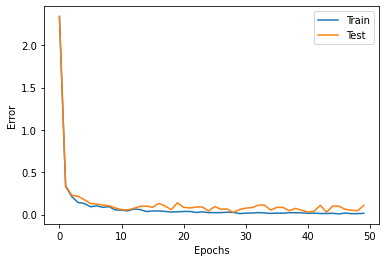

Accuracy Train: 100.0% Accuracy Test: 97.9966611018364%


In [10]:
# -- 誤差の記録用 --
train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

n_batch = n_train // batch_size
for i in range(epoch):

    # 誤差計算 
    x, t = forward_sample(input_train, correct_train, n_sample)
    error_train = get_error(t, n_sample)
    x, t = forward_sample(input_test, correct_test, n_sample) 
    error_test = get_error(t, n_sample)
    
    # -- 誤差の記録 -- 
    train_error_x.append(i)
    train_error_y.append(error_train) 
    test_error_x.append(i)
    test_error_y.append(error_test) 
    
    # -- 経過の表示 --
    if i%interval == 0:
        print("Epoch:" + str(i) + "/" + str(epoch),
              "Error_train:" + str(error_train),
              "Error_test:" + str(error_test))
    
    # -- 学習 -- 
    index_rand = np.arange(n_train)
    np.random.shuffle(index_rand)   
    for j in range(n_batch):
        
        mb_index = index_rand[j*batch_size : (j+1)*batch_size]
        x = input_train[mb_index, :]
        t = correct_train[mb_index, :]

        forward_propagation(x)
        backpropagation(t)        
        uppdate_wb() 
            
    
# -- 誤差の記録をグラフ表示 -- 
plt.plot(train_error_x, train_error_y, label="Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

# -- 正解率の測定 -- 
x, t = forward_sample(input_train, correct_train, n_train) 
count_train = np.sum(np.argmax(ol_1.y, axis=1) == np.argmax(t, axis=1))

x, t = forward_sample(input_test, correct_test, n_test) 
count_test = np.sum(np.argmax(ol_1.y, axis=1) == np.argmax(t, axis=1))

print("Accuracy Train:", str(count_train/n_train*100) + "%",
      "Accuracy Test:", str(count_test/n_test*100) + "%")